# Playground notebook

## Imports and settings

In [1]:
import src
import os
import numpy as np
import io

import sys
import re
import pickle
import math
import blosc
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from  matplotlib.animation import FuncAnimation
from matplotlib import colors
from netCDF4 import Dataset
from IPython.display import clear_output
#data folder
sys.path.insert(0, 'C:/Users/pkicsiny/Desktop/TUM/3/ADL4CV/data')

#forces CPU usage
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0" #"" for CPU
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
from matplotlib import animation

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12487427116141177038
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1508248780
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11608430226121913441
physical_device_desc: "device: 0, name: GeForce GT 740M, pci bus id: 0000:01:00.0, compute capability: 3.5"
]


______________________________________-
## Data preprocessing

### Rain measurements
Measurements are downloaded from the DWD (German weather service) open data server: __ftp://ftp-cdc.dwd.de/pub/CDC/grids_germany/hourly/__<br>
I'm working with the data of August 2010 (based on [this](https://tradingeconomics.com/germany/precipitation)), so I have downloaded this: __ftp://ftp-cdc.dwd.de/pub/CDC/grids_germany/hourly/radolan/historical/asc/2010/RW-201008.tar__<br>
_DWD manual:_<br>
__ftp://ftp-cdc.dwd.de/pub/CDC/grids_germany/hourly/radolan/historical/asc/BESCHREIBUNG_gridsgermany_hourly_radolan_historical_asc_de.pdf__<br><br>
This contains radar maps recorded in every hour. Each map has a resolution of $900\times900$ pixels and each pixel corresponds to an $1\,km\times1\,km$ area in reality. Pixel values are the precipitation height in $0.1\,mm$.
Below I'm importing the data of this as a series of numpy arrays and plot them to see the acual radar map. The _sys.path[0]_ is the path on my computer and it can be different for you.
<br>
The data with hourly resolutions spans from 1995 to 2012.<br><br>
Additionally there is data with 5 minutes resolution available here: 
https://opendata.dwd.de/weather/radar/composit/rx/<br>
The span of this is the last two days and it is updated constantly.
_______________

Use this cell to load 5 minutes data from filtes:

In [2]:
inputs = src.get_data(sys.path[0]+"/rain_5min", which="5min", mask=True)

[578/578]
C:/Users/pkicsiny/Desktop/TUM/3/ADL4CV/data/rain_5min/raa01-rx_10000-latest-dwd---bin


Use the cell below to load hourly rain+wind data from the files.<br>
Rain file was generated before from the hourly dataset by interpolating it to the wind map grid.

In [ ]:
rho = Dataset(sys.path[0]+"/rain_density/rho.nc")["field"]
w_dir = Dataset(sys.path[0]+'/wind_direction/DD_201008_CF.nc')["DD"]  # direction DD

This cell generates the deep learning datasets by cutting small frames from the maps:

In [6]:
import time
t = time.time()
images = src.generate_datasets(inputs, size=64, length=8, n=10000, normalize=True, split=(75, 15, 10))
print("Elapsed time:",time.time() - t)

Shape of data: (10000, 64, 64, 8)

Training set: (7500, 64, 64, 8)
Validation set: (1500, 64, 64, 8)
Test set: (1000, 64, 64, 8)
Elapsed time: 1320.0138447284698


In [12]:
src.compress_huge_data(images["norm factors"], "norms")
src.compress_huge_data(images["train"], "train")
src.compress_huge_data(images["xval"], "xval")
src.compress_huge_data(images["test"], "test")

In [7]:
train = images["train"]

In [8]:
len(train[-1][train[-1] == 0])

18807

In [9]:
len(train[-1].flatten())

32768

Loop over the created samples.

<IPython.core.display.Javascript object>


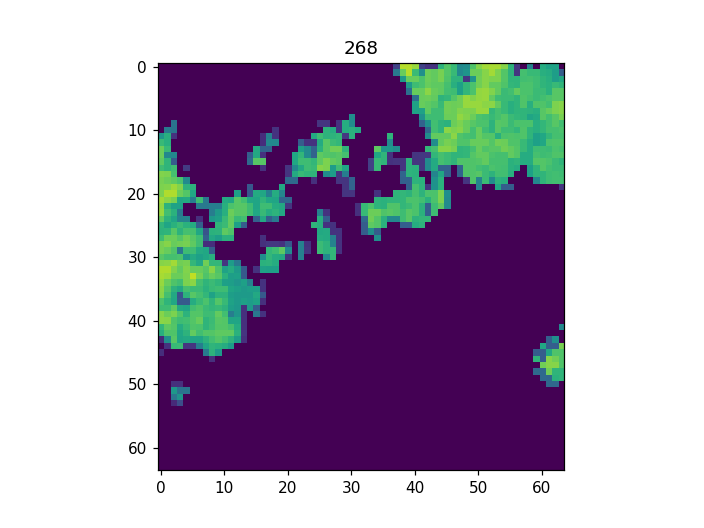

In [11]:
%matplotlib notebook
from  matplotlib.animation import FuncAnimation

fig = plt.figure()
plot = plt.imshow(train[0,:,:,0]) #inputs 100 has a good mask
def update(i):
    plot.set_data(train[i,:,:,0])
    plt.title(i)
    return plot

anim = FuncAnimation(fig, update, frames=1000, interval = 100, blit=True, repeat=False)


plt.show()

In [ ]:
channel = 0
sample = 56
dataset = train
plt.subplot(2,4,1)
plt.imshow(dataset[sample,:,:,0])
plt.colorbar()
plt.subplot(2,4,2)
plt.imshow(dataset[sample,:,:,1])
plt.colorbar()
plt.subplot(2,4,3)
plt.imshow(dataset[sample,:,:,2])
plt.colorbar()
plt.subplot(2,4,4)
plt.imshow(dataset[sample,:,:,3])
plt.colorbar()
plt.subplot(2,4,5)
plt.imshow(dataset[sample,:,:,4])
plt.colorbar()
plt.subplot(2,4,6)
plt.imshow(dataset[sample,:,:,5])
plt.colorbar()
plt.subplot(2,4,7)
plt.imshow(dataset[sample,:,:,6])
plt.colorbar()
plt.subplot(2,4,8)
plt.imshow(dataset[sample,:,:,7])
plt.colorbar()

If you have split the data you can use this cell to compress the data and save it to the selected folder:

In [ ]:
src.compress_huge_data(images["train"], filename="5min_train")
src.compress_huge_data(images["xval"], filename="5min_xval")
src.compress_huge_data(images["test"], filename="5min_test")

Use this cell below to load preprocessed data from file.

In [ ]:
t, v, s = src.load_datasets("5min", past_frames=4, future_frames=5)

____
### Wind measurements
Here I'm loading wind measurements. This is important because later we might experiment not only with rain (the density field) but with the wind (velocity field) too. This is because in the [tempoGAN](https://arxiv.org/pdf/1801.09710.pdf) paper they also use the velocity and without it that might be very difficult to build the GAN. I have downloaded two datasets for the wind:<br><br>
_Wind direction:_ __ftp://ftp-cdc.dwd.de/pub/CDC/grids_germany/hourly/Project_TRY/wind_direction/DD_201208.nc.gz__<br>
_Wind speed:_ __ftp://ftp-cdc.dwd.de/pub/CDC/grids_germany/hourly/Project_TRY/wind_speed/FF_201208.nc.gz__<br>
_DWD manuals:_<br>
__ftp://ftp-cdc.dwd.de/pub/CDC/grids_germany/hourly/Project_TRY/wind_direction/DESCRIPTION_gridsgermany_hourly_Project_TRY_wind_direction_en.pdf__
<br>
__ftp://ftp-cdc.dwd.de/pub/CDC/grids_germany/hourly/Project_TRY/wind_speed/DESCRIPTION_gridsgermany_hourly_Project_TRY_wind_speed_en.pdf__<br><br>
I create two datasets out of these. They contain the $x$ and $y$ velocity components.
The measurements are in $\displaystyle0.1\,\frac{m}{s}$.
<br><br>
_<font color='red'>__Issue__:</font> [Mostly](https://www.nationalgeographic.com/science/earth/earths-atmosphere/clouds/) an average rain cloud is at $2000\,m$ high. Normal clouds can be up to $6000\,m$ high. We only have wind measurements recorded at $10\,m$. 
We can use e.g. [this](https://websites.pmc.ucsc.edu/~jnoble/wind/extrap/) to calculate wind speed at higher altitudes. We can't correct the change in wind direction so this remains a weak point in the simulations._

In [ ]:
#the paths are probably different for you
w_dir = Dataset(sys.path[0]+'/wind_direction/DD_201008_CF.nc')  # direction DD
w_vel = Dataset(sys.path[0]+'/wind_speed/FF_201008_CF.nc')  # velocity FF
cloud = Dataset(sys.path[0]+'/cloud/N_201008_CF.nc')  # cloud cover CF

In [ ]:
w_vel["datum"][743]

This reads wind direction and magnitude datasets. They are hourly distributed and I use the dataset of 2010. August. The dates of the measurements begin with 2018.08.01.00:00:00. There are 744 = 24$\cdot$31 maps, each 938*720 pixels. This cell below is very memory consuming so this is just a demonstration here to look over the data.

In [ ]:
#creating vx and vy datasets from |v| and phi
vx = np.ma.masked_where(np.ma.getmask(w_dir['DD'][:10]), np.zeros(w_dir['DD'][:10].shape))
vy = np.ma.masked_where(np.ma.getmask(w_dir['DD'][:10]), np.zeros(w_dir['DD'][:10].shape))
for t in range(np.shape(vx)[0]):
    src.update_output(f"[{t+1}/{np.shape(vx)[0]}]")
    vx[t] = np.flip(w_vel["FF"][t]*np.sin(np.deg2rad(w_dir['DD'][t])),axis = 0)
    vy[t] = np.flip(w_vel["FF"][t]*np.cos(np.deg2rad(w_dir['DD'][t])),axis = 0)

This cell below extract the radar grid of these wind measurements. So a $938\cdot720$ long dataframe is created with the latitude and longitude coordinates of the center of each grid point. The individual cells are labeled with a cell ID which is just an integer value similar to the index.

In [ ]:
#gps grid of wind maps
#47.075
wind_grid = pd.DataFrame(data={'LAT':w_vel['lat'][:].flatten(),
                               'LON':w_vel['lon'][:].flatten()}).reset_index().rename(columns={"index":"CELL_ID"})

Here I plot some examples for sanity check that the wind direction is preserved after the velocity x and y calculation.

In [ ]:
#sanity checks
%matplotlib notebook
idx = 0
fig = plt.figure(figsize=(8,8))
# NE, N, NW
plt.subplot(2,2,1)
plt.imshow(np.ma.masked_where(vy[idx] < 0, vy[idx]))
plt.colorbar(shrink=0.7)
plt.title("All northern wind")

plt.subplot(2,2,2)
plt.imshow(np.flip(np.ma.masked_where((w_dir['DD'][idx]>=90)& (w_dir['DD'][idx]<=270),w_dir['DD'][idx] ), axis=0))
plt.colorbar(shrink=0.7)
plt.title("All northern wind truth")

# SW
plt.subplot(2,2,3)
plt.imshow(np.ma.masked_where((vy[idx]>0)|(vx[idx]>0), vy[idx]))
plt.colorbar(shrink=0.7)
plt.title("Southwestern wind")

plt.subplot(2,2,4)
plt.imshow(np.flip(np.ma.masked_where((w_dir['DD'][idx]<180)| (w_dir['DD'][idx]>270),w_dir['DD'][idx] ), axis=0))
plt.colorbar(shrink=0.7)
plt.title("Southwestern wind truth")

plt.subplots_adjust(hspace=0.3, wspace=0.3)

## Visualise channels
__<font color='red'>SHOW</font>__

This part is valid if one already has the rain data interpolated to the wind grid. If not scroll down for some info on it.

In [ ]:
v = np.zeros((3,3,3))
a.shape

In [ ]:
d = np.concatenate((v,v))

In [ ]:
d.shape

In [ ]:
np.shape(d[0:1,0:2,0:2])

In [ ]:
np.shape([s[0:2,0:2] for s in d[0:1]])

In [ ]:
a[:,:].shape

In [ ]:
a[:,:,0].shape

In [ ]:
a[:,:,0:1].shape

In [ ]:
rho = Dataset(sys.path[0]+"/rain_density/rho.nc")

In [ ]:
%matplotlib notebook
#visualise channels
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5,figsize=(12,12))
for ax in [ax1,ax2,ax3,ax4, ax5]:
    ax.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    left=False,      # ticks along the top edge are off
    labelbottom=False,
    labelleft=False) # labels along the bottom edge are off
ax1.set_title("Rain density")
ax2.set_title("Cloud density")
ax3.set_title("Wind velocity x")
ax4.set_title("Wind velocity y")
ax5.set_title("Wind direction")
line1 = ax1.imshow(rho["field"][0]) # start from index 0 which means 0:50:00
line2 = ax2.imshow(np.flip(cloud["CF"][1],axis = 0)) # start from index 1 which means 1:00:00
line3 = ax3.imshow(-np.flip(np.sin(np.deg2rad(w_dir['DD'][1])),axis = 0),cmap="seismic")
line4 = ax4.imshow(-np.flip(np.cos(np.deg2rad(w_dir['DD'][1])),axis = 0),cmap="seismic")
line5 = ax5.imshow(np.flip(w_dir["DD"][1],axis = 0),cmap="terrain")
line = [line1, line2, line3, line4, line5]

sh = 0.15
fig.colorbar(line1, ax=ax1,shrink=sh)
fig.colorbar(line2, ax=ax2,shrink=sh)
fig.colorbar(line3, ax=ax3,shrink=sh)
fig.colorbar(line4, ax=ax4,shrink=sh)
fig.colorbar(line5, ax=ax5,shrink=sh)

def run(i):
    line[0].set_data(rho["field"][i])
    line[1].set_data(np.flip(cloud["CF"][i+1],axis = 0))
    line[2].set_data(-np.flip(np.sin(np.deg2rad(w_dir['DD'][i+1])),axis = 0))
    line[3].set_data(-np.flip(np.cos(np.deg2rad(w_dir['DD'][i+1])),axis = 0))
    line[4].set_data(np.flip(w_dir["DD"][i+1],axis = 0))
    fig.suptitle(f"Index in array: {i}")
    return line

ani = animation.FuncAnimation(fig, run, blit=True, interval=400, frames=500,
    repeat=False)
plt.show()

### Create datasets for temporal GAN

In [ ]:
test = generate_tempoGAN_datasets(rho["field"], w_vel["FF"], w_dir["DD"], n=10,length=4, normalize=True)

In [ ]:
sample=8
plt.subplot(3,4,1)
plt.imshow(test[sample,0,:,:,0])
plt.colorbar(shrink=0.3)
plt.axis('off')
plt.subplot(3,4,2)
plt.imshow(test[sample,1,:,:,0])
plt.colorbar(shrink=0.3)
plt.axis('off')
plt.subplot(3,4,3)
plt.imshow(test[sample,2,:,:,0])
plt.colorbar(shrink=0.3)
plt.axis('off')
plt.subplot(3,4,4)
plt.imshow(test[sample,3,:,:,0])
plt.colorbar(shrink=0.3)
plt.axis('off')

plt.subplot(3,4,5)
plt.imshow(test[sample,0,:,:,1])
plt.colorbar(shrink=0.3)
plt.axis('off')
plt.subplot(3,4,6)
plt.imshow(test[sample,1,:,:,1])
plt.colorbar(shrink=0.3)
plt.axis('off')
plt.subplot(3,4,7)
plt.imshow(test[sample,2,:,:,1])
plt.colorbar(shrink=0.3)
plt.axis('off')
plt.subplot(3,4,8)
plt.imshow(test[sample,3,:,:,1])
plt.colorbar(shrink=0.3)
plt.axis('off')

plt.subplot(3,4,9)
plt.imshow(test[sample,0,:,:,2])
plt.colorbar(shrink=0.3)
plt.axis('off')
plt.subplot(3,4,10)
plt.imshow(test[sample,1,:,:,2])
plt.colorbar(shrink=0.3)
plt.axis('off')
plt.subplot(3,4,11)
plt.imshow(test[sample,2,:,:,2])
plt.colorbar(shrink=0.3)
plt.axis('off')
plt.subplot(3,4,12)
plt.imshow(test[sample,3,:,:,2])
plt.colorbar(shrink=0.3)
plt.axis('off')

In [ ]:
size=64
time = 743
h = rho["field"][0].shape[0] #938
w = rho["field"][0].shape[1] #720
length = 4
image = np.empty((length,size,size,3))
anchor = (np.random.randint(0, time - 2), np.random.randint(0, h - size), np.random.randint(0, w - size))
print(anchor)
for i in range(length):
    r = rho["field"][anchor[0]+i]
    x = -np.flip(np.sin(np.deg2rad(w_dir["DD"][anchor[0]+1+i])),axis = 0)
    y = -np.flip(np.cos(np.deg2rad(w_dir["DD"][anchor[0]+1+i])),axis = 0)
    image[i,:,:,0] = r[anchor[1]:anchor[1] + size, anchor[2]:anchor[2] + size].filled(np.nan)
    image[i,:,:,1] = x[anchor[1]:anchor[1] + size, anchor[2]:anchor[2] + size].filled(np.nan)
    image[i,:,:,2] = y[anchor[1]:anchor[1] + size, anchor[2]:anchor[2] + size].filled(np.nan)

# Machting rain cells to wind cells
Don't run this if the rain density data on the wind grid is available.

### Radar coordinates
The gps coordinates of the radar grid for the rain measurements.

In [ ]:
coords = src.get_rain_grid_coords()

In [ ]:
reduced_coords = coords[coords["LON"]>= germany["LON"].min()]
reduced_coords

### Germany
GPS coordinates of Germany. This is a subset of the wind grid. As next I'm matching wind grid cells with the nearest rain cells. As seen on the plot below, the rain and wind data comes from a different radar measurement method so they have a different grid map so the grid points are not identical.

In [ ]:
try:
    with open('germany.pickle', 'rb') as handle:
        germany = pickle.load(handle)
except:
    #this takes 1 night
    src.get_germany(w_vel, coords)
germany

In [ ]:
%matplotlib notebook

#plot wind grid
plt.scatter(wind_grid["LON"], wind_grid["LAT"],s=0.2, label="wind grid")
#plot rain grid
plt.scatter(coords["LON"], coords["LAT"],s=0.2, label="rain grid")
#plot wind grid points inside Germany
plt.scatter(germany["LON"],germany["LAT"],s=10, label="Germany on wind grid")
#plot rain grid points that are the nearest neighbors to each wind grid cell inside Germany
#plt.scatter(coords.iloc[germany["CLOSEST_RAIN_CELL_ID"]]["LON"],
#            coords.iloc[germany["CLOSEST_RAIN_CELL_ID"]]["LAT"],
#            s=10, label="rain grid")

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Rain and wind radar grids")
lgnd = plt.legend(loc="lower right")
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
lgnd.legendHandles[2]._sizes = [30]
plt.savefig("grids.png")

Create density channel (rain) with the grid of the wind maps. We need 3 channels: [rain,vx,vy]<br>
Since the wind data is available until the end of 2012, we can only create three channels using the hourly resolution. 5 min data is available only for the past 48 hours.

In [ ]:
rho = np.ma.masked_where(np.flip(np.ma.getmask(w_dir['DD'][:144]),axis=1),
                         np.zeros((144,w_dir['DD'].shape[1],w_dir['DD'].shape[2])))
rho[:,938-germany["CELL_ID"]//720,
    germany["CELL_ID"]%720] = inputs[600:,900-germany["CLOSEST_RAIN_CELL_ID"]//900, germany["CLOSEST_RAIN_CELL_ID"]%900]
rho.shape

In [ ]:
%matplotlib notebook
idx = 45
plt.subplot(1,3,1)
plt.imshow(np.ma.masked_where(inputs[200+idx] < 0,inputs[200+idx]))
plt.title("RADOLAN rain")
plt.subplot(1,3,2)
plt.imshow(rho[idx])
plt.title("Interpolated rain")
plt.subplot(1,3,3)
plt.imshow(vy[idx])
plt.title("Wind")
plt.show()

In [ ]:
new = np.ma.concatenate((a["field"][:], rho), axis=0)

Creating .nc file.

In [ ]:
#root_grp.close()
root_grp = Dataset('rho.nc', 'w', format='NETCDF4')
root_grp.description = 'Example simulation data'

lat_n = 938
lon_n = 720
xdimension = 0.75
ydimension = 0.75
# dimensions
root_grp.createDimension('time', None)
root_grp.createDimension('lat', lat_n)
root_grp.createDimension('lon', lon_n)

# variables
time = root_grp.createVariable('time', 'c', ('time',))
x = root_grp.createVariable('lat', 'c', ('lat',))
y = root_grp.createVariable('lon', 'c', ('lon',))
field = root_grp.createVariable('field', 'f4', ('time', 'lat', 'lon',))

field[:,:,:] = new

root_grp.close()

In [ ]:
# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

    # Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)